In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Imports

# third party
import jax
import jax.numpy as jnp
from jax._src.config import config
import matplotlib.pyplot as plt 
config.update("jax_enable_x64", True)
import pandas as pd

#need to get rid of
import numpy as np

# project
from ndjeans import models

In [5]:
# load test_data
rawdata = pd.read_csv('data/gs010_bs050_rcrs025_rarcinf_cusp_0064mpc3_df_100_3_err.dat')

R = jnp.sqrt(jnp.array(rawdata['x']**2+rawdata['y']**2))
vlos = jnp.array(rawdata['vz'])

data = jnp.array([R,vlos])
data.shape

error = jnp.full_like(vlos,2)

In [6]:
# set up model
# ------------
# model for tracers
tracer_model = models.Plummer  # other options include exponential, king,
n_tracer     = 1               # number of plummer components to fit to data

# stellar anisotropy model
beta_model = models.gOM #options: constant, OM (osipkov-merrit), gOM (for cases with tangential orbits are possible)

# Do you want to fit multiple metallicity components
n_pop = 1 # number of metallicity components

dm_model = models.HernquistZhao # other options are NFW, gNFW, exponential
n_dm     = 1                    # number of dm components to fit 


In [7]:
#temporary
G  = 4.5171031e-39 # Gravitational constant [kpc**3 solMass**-1 s**-2] 
#need different accuracy for each integral
xmass,wmass  = np.loadtxt('/Users/juan/phd/projects/weird-jeans/src/data/gausleg_10',delimiter=',')

xmass = jnp.array(xmass)
wmass = jnp.array(wmass)

xdisp,wdisp  = np.loadtxt('/Users/juan/phd/projects/weird-jeans/src/data/gausleg_100',delimiter=',')

xdisp = jnp.array(xdisp)
wdisp = jnp.array(wdisp)

@jax.jit
def density(r,rhos : float,rs : float, a : float, b : float, c : float):
    '''
    Hernquist-Zhao density profile

    Parameters
    ----------
    r : _type_
        _description_
    rhos : float
        _description_
    rs : float
        _description_
    a : float
        _description_
    b : float
        _description_
    c : float
        _description_

    Returns
    -------
    _type_
        _description_
    '''
    q = r/rs
    nu = (a-c)/b
    return rhos * q**-a * (1+q**b)**(nu)

density_grad = jax.vmap(jax.grad(density),in_axes=(0,None,None,None,None,None))


from ndjeans.models import JeansOM

def logslope(r,rhos,rs,a,b,c):
    return -r*density_grad(r,rhos,rs,a,b,c)/density(r,rhos,rs,a,b,c)


x0 = 0.0
x1 = jnp.pi/2

# Gauss-Legendre integration
xi = 0.5*(x1-x0)*xmass + .5*(x1+x0) # scale from (r,r_{200}) -> (-1,1)
wi = 0.5*(x1-x0)*wmass
s = jnp.cos(xi)
w = jnp.sin(xi)

@jax.jit
def mass_integral(r,rhos,rs,a,b,c):
    
    coeff = 4*jnp.pi * rhos*rs**3* r
    # return coeff*jnp.sum(wi*jnp.cos(xi)*(r*jnp.sin(xi))**2 * density(r*jnp.sin(xi),1.0,1.0,a,b,c))
    return coeff*jnp.sum(wi*s*(r*w)**2 * density(r*w,1.0,1.0,a,b,c))

vec_mass  = jax.vmap(mass_integral,in_axes=(0, None,None,None, None,None))
# mass = vec_mass(r,rhos,rs,a,b,c)

# vec_mass  = jax.vmap(JeansOM.mass,in_axes=(0, None,None,None, None,None))
@jax.jit
def func(q,rhos,rs,a,b,c):

    return vec_mass(q,rhos,rs,a,b,c)*JeansOM.nu(q,0.25)/q**2
@jax.jit
def dispersion_integral(r,rhos,rs,a,b,c):
    x0 = 0.0
    x1 = jnp.pi/2.0

    # Gauss-Legendre integration
    xi = 0.5*(x1-x0)*xdisp + .5*(x1+x0)
    wi = 0.5*(x1-x0)*wdisp
    coeff = G*r

    return coeff*jnp.sum(wi*jnp.cos(xi)*func(r/jnp.sin(xi),rhos,rs,a,b,c)/jnp.sin(xi)**2,axis=0)

vec_dispn = jax.vmap(dispersion_integral,in_axes=(0,None, None,None,None,None)) # this is the Gauss-Legendre method




@jax.jit
def func2(x,R_,rhos,rs,a,b,c):
    sn = vec_dispn(x,rhos,rs,a,b,c)
    return sn*x/jnp.sqrt(x**2-R_**2)

xcg = np.loadtxt('/Users/juan/phd/projects/weird-jeans/src/data/ChebyGauss100_x.txt')
wcg = np.loadtxt('/Users/juan/phd/projects/weird-jeans/src/data/ChebyGauss100_w.txt')
xcg = jnp.array(xcg)
wcg = jnp.array(wcg)

y0 = 0        # lowerbound 
y1 = jnp.pi/2 # upperbound
# Modified weights and points for 
xk = 0.5*(y1-y0)* xdisp + 0.5*(y1+y0) 
wk = 0.5*(y1-y0)* wdisp 

cosk= jnp.cos(xk)
sink = jnp.sin(xk)
@jax.jit
def test_dispersion(R_: float,rhos: float,rs: float,a: float,b: float,c: float) -> float:
    '''
    first using the transform y = rcsc(x)
    then using Gauss-Legendre transformation.
    using the transform x = 
    '''
    # y0 = 0        # lowerbound 
    # y1 = jnp.pi/2 # upperbound
    # # Modified weights and points for 
    # xk = 0.5*(y1-y0)* xdisp + 0.5*(y1+y0) 
    # wk = 0.5*(y1-y0)* wdisp 
    # return 2* R_* jnp.sum(wk*jnp.cos(xk)*func2(R_/jnp.sin(xk),R_,rhos,rs,a,b,c)/jnp.sin(xk)**2,axis=0)/JeansOM.projected_stars(R_,0.25)
    return 2* R_* jnp.sum(wk*cosk*func2(R_/sink,R_,rhos,rs,a,b,c)/sink**2,axis=0)/JeansOM.projected_stars(R_,0.25)

vec_dispb = jax.vmap(test_dispersion,in_axes=(0, None, None,None,None,None))

In [8]:
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

In [15]:
def model(
    data,
    error,
    ):
    m_rhos = numpyro.sample("m_rhos", dist.Normal(9, 1)  ) # log_{10}{scale density} -- dont want negatives 
    m_rs   = numpyro.sample("m_rs"  , dist.Normal(0, 1)  )   # log_{10}{scale density} -- dont want negatives 
    m_a    = numpyro.sample("m_a"   , dist.Uniform(-1,3) )
    m_b    = numpyro.sample("m_b"   , dist.Uniform(.5,3) )
    m_c    = numpyro.sample("m_c"   , dist.Uniform(1,5)  )

    m = 10**m_rhos
    b = 10**m_rs 

    sigma2 = vec_dispb(data[0,:],m,b,m_a,m_b,m_c) + error**2
    with numpyro.plate("data", len(data[1])):

        numpyro.sample("y", dist.Normal(data[1,:],sigma2), obs=data[1:])



In [16]:
# Start from this source of randomness. We will split keys for subsequent operations.
from jax import random
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(rng_key_,data= data,error=error)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [50:08<00:00,  1.00s/it, 7 steps of size 7.63e-01. acc. prob=0.89]  


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       m_a      0.99      1.19      1.03     -0.90      2.74   2245.01      1.00
       m_b      1.73      0.73      1.73      0.51      2.74   2613.19      1.00
       m_c      3.01      1.16      3.00      1.10      4.69   2574.33      1.00
    m_rhos      8.99      0.99      9.00      7.28     10.55   2081.81      1.00
      m_rs     -0.01      0.98     -0.02     -1.52      1.69   2439.11      1.00

Number of divergences: 0


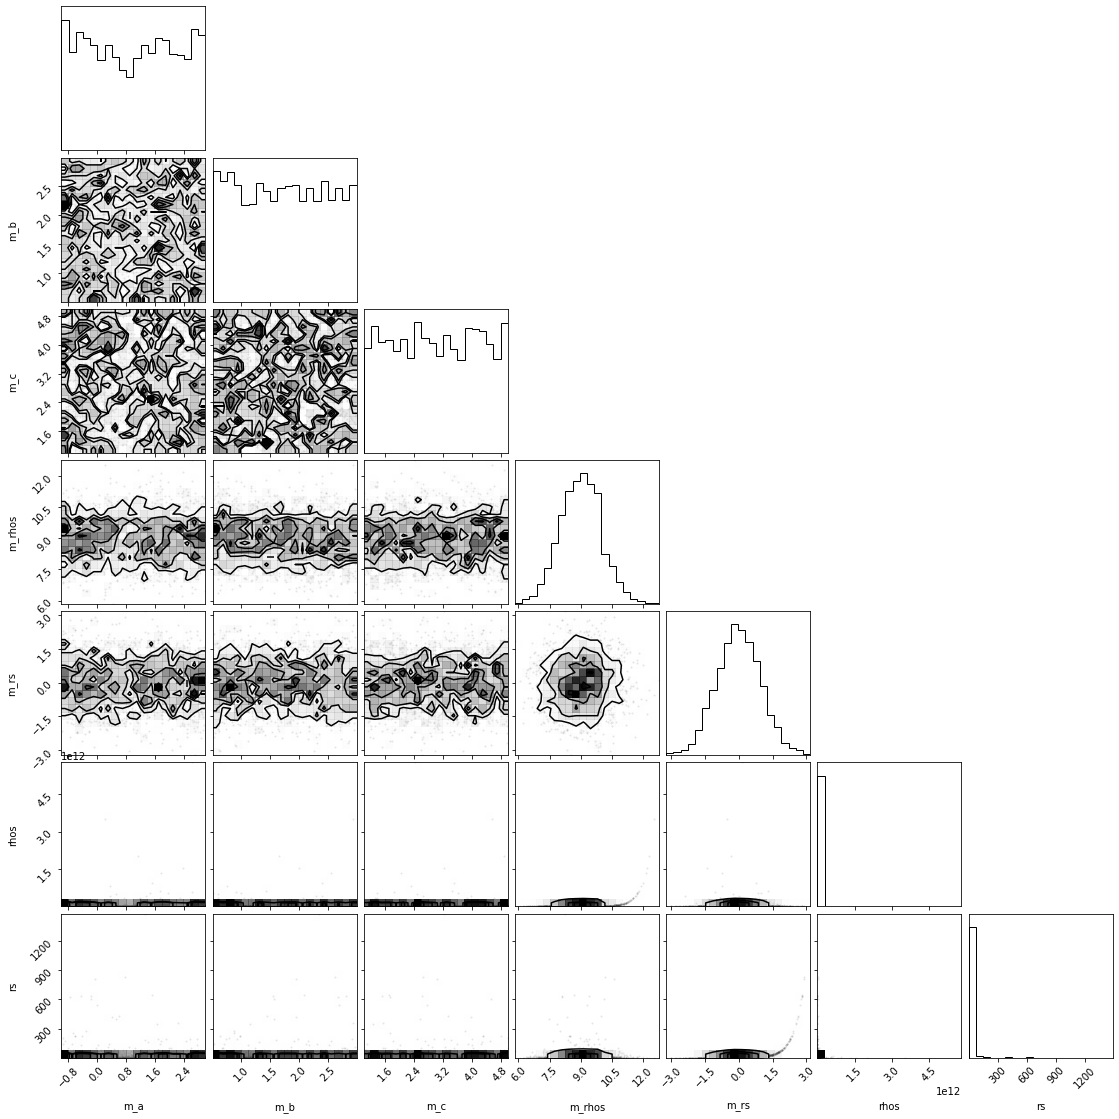

In [17]:
import corner
import arviz as az

# inf_data = az.from_numpyro(samples_1)

corner.corner(samples_1);

In [18]:
def model_flat(
    data,
    error,
#     stellar_model,
#     n_tracer,
    # dm_model,
    # n_dm,
    # beta_model,
    # n_pop
    ):
# def model():
    m_rhos = numpyro.sample("m_rhos", dist.Uniform(5,30))   # log_{10}{scale density} -- dont want negatives 
    m_rs   = numpyro.sample("m_rs", dist.Uniform(-10, 10))  # log_{10}{scale density} -- dont want negatives 
    m_a    = numpyro.sample("m_a", dist.Uniform(-1,5))
    m_b    = numpyro.sample("m_b", dist.Normal(1,1))
    m_c    = numpyro.sample("m_c", dist.Normal(3,1))
    # m_d    = numpyro.sample("m_d",dist.Normal(np.ones(5),np.ones(5))) # agh ok so this works, yay!
    m = 10**m_rhos
    b = 10**m_rs

    sigma2 = vec_dispb(data[0,:],m,b,m_a,m_b,m_c) + error**2
    with numpyro.plate("data", len(data[1])):
        numpyro.sample("y", dist.Normal(data[1,:],sigma2), obs=data[1:])

    # return -1

In [19]:
# Start from this source of randomness. We will split keys for subsequent operations.
from jax import random
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model_flat)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(rng_key_,data= data,error=error)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

warmup:  10%|█         | 300/3000 [11:31<2:08:47,  2.86s/it, 31 steps of size 9.74e-02. acc. prob=0.78] 